In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from google.colab import files

Here I upload the Alzheimer dataset from Kaggle


In [2]:

files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images
!unzip alzheimers-dataset-4-class-of-images.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s D

Preprocessing

In [3]:
#Here we define some parameters that we'll probably need to change later on
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 10
IMAGE_SIZE = [176, 208]
#IMAGE_SIZE = [224, 224]
EPOCHS = 60

#We are loading our dataset using the Keras preprocessing feature, Splitting the Training dataset into 80% for training and 20% for validation
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="training",
    seed=999,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=999,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


in /content/Alzheimer_s Dataset/train/NonDemented/ 2560
in /content/Alzheimer_s Dataset/train/VeryMildDemented/ 1792
in /content/Alzheimer_s Dataset/train/ModerateDemented/ 52
in /content/Alzheimer_s Dataset/train/MildDemented/ 717


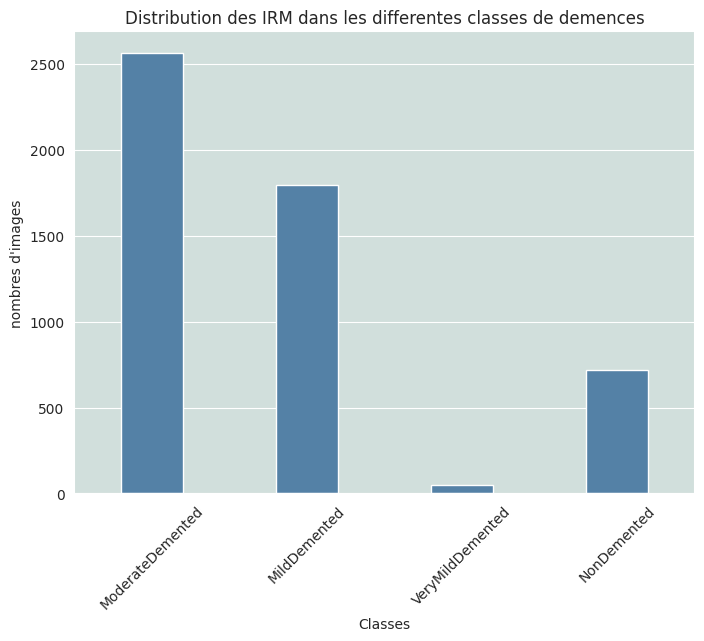

In [6]:

path='/content/Alzheimer_s Dataset/train/'
Folders = []
for name in os.listdir("/content/Alzheimer_s Dataset/train"):
  i=path+name+'/'
  Folders.append(i)

counts = []
for count in Folders:
  print("in", count, len(os.listdir(count)))
  counts.append(len(os.listdir(count)))

fig = plt.figure(figsize=(8, 6))
labels = ['ModerateDemented', 'MildDemented', 'VeryMildDemented', 'NonDemented']
plt.xticks(rotation=45)
plt.title('Distribution des IRM dans les differentes classes de demences')
plt.xlabel('Classes')
plt.ylabel("nombres d'images")
sns.barplot(x=labels, y=counts, width=0.4, color='steelblue')
sns.set_style("darkgrid",{'axes.facecolor': '#D1DFDC'})
plt.show()

In [ ]:
#Defining the class names
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_dataset.class_names = class_names
val_dataset.class_names = class_names
NUM_CLASSES = len(class_names)

#We use the one hot encoding because we have categorical data that we need to convert it into numerical data
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_dataset = train_dataset.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(one_hot_label, num_parallel_calls=AUTOTUNE)


In [ ]:
#We first define 3 sequential models for all our pre-trained models
resnet_model = Sequential()
Xception_model = Sequential()
VGG_model = Sequential()

#We imported here the ResNet50
pretrained_model_1 = tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224, 3),
                   pooling='avg',
                   classes=4,
                   weights='imagenet')


#We imported here Xception
pretrained_model_2 = tf.keras.applications.Xception(include_top=False,
                  weights="imagenet",
                  input_shape=(224,224, 3),
                  pooling='avg',
                  classes=4)


#We imported here VGG16
pretrained_model_3 = tf.keras.applications.VGG16(include_top=False,
                  weights="imagenet",
                  input_shape=(224,224, 3),
                  pooling='avg',
                  classes=4,
)

#Now we freeze all the models layers
for layer in pretrained_model_1.layers:
        layer.trainable=False

for layer in pretrained_model_2.layers:
        layer.trainable=False

for layer in pretrained_model_3.layers:
        layer.trainable=False

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
#Finetuning Resnet
resnet_model.add(pretrained_model_1)
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(128, activation='relu'))
resnet_model.add(tf.keras.layers.Dropout(0.2))
resnet_model.add(tf.keras.layers.Dense(64, activation='relu'))
resnet_model.add(tf.keras.layers.Dense(4, activation='softmax'))

#Finetuning Xception

Xception_model.add(pretrained_model_2)
Xception_model.add(tf.keras.layers.Flatten())
Xception_model.add(tf.keras.layers.Dense(128, activation='relu'))
Xception_model.add(tf.keras.layers.Dropout(0.2))
Xception_model.add(tf.keras.layers.Dense(64, activation='relu'))
Xception_model.add(tf.keras.layers.Dense(4, activation='softmax'))

#Finetuning VGG16
VGG_model.add(pretrained_model_3)
VGG_model.add(tf.keras.layers.Flatten())
VGG_model.add(tf.keras.layers.Dense(128, activation='relu'))
VGG_model.add(tf.keras.layers.Dropout(0.2))
VGG_model.add(tf.keras.layers.Dense(64, activation='relu'))
VGG_model.add(tf.keras.layers.Dense(4, activation='softmax'))


In [ ]:
resnet_model.summary()
Xception_model.summary()
VGG_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                                 
Total params: 23,858,500
Trainable params: 270,788
Non

LE FINE-TUNING EN UTILISANT LE RESNET

In [ ]:
#We use AUC as our main matrix because our data isn't balanced, and we also use the accuracy
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
                        tf.keras.metrics.AUC(name='auc'),
                        tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn')
                        ]

In [ ]:
resnet_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS)

history = resnet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/60
410/410 [==============================] - 28s 55ms/step - loss: 1.0197 - acc: 0.5132 - auc: 0.7920 - tp: 2039.0000 - fp: 1531.0000 - tn: 14597.0000 - fn: 3337.0000 - val_loss: 0.8844 - val_acc: 0.5830 - val_auc: 0.8532 - val_tp: 352.0000 - val_fp: 126.0000 - val_tn: 2946.0000 - val_fn: 672.0000
Epoch 2/60
410/410 [==============================] - 20s 50ms/step - loss: 0.9495 - acc: 0.5360 - auc: 0.8249 - tp: 1426.0000 - fp: 796.0000 - tn: 11495.0000 - fn: 2671.0000 - val_loss: 0.9597 - val_acc: 0.5244 - val_auc: 0.8203 - val_tp: 217.0000 - val_fp: 46.0000 - val_tn: 3026.0000 - val_fn: 807.0000
Epoch 3/60
410/410 [==============================] - 20s 47ms/step - loss: 0.9069 - acc: 0.5619 - auc: 0.8411 - tp: 1545.0000 - fp: 758.0000 - tn: 11533.0000 - fn: 2552.0000 - val_loss: 0.8581 - val_acc: 0.6016 - val_auc: 0.8675 - val_tp: 367.0000 - val_fp: 89.0000 - val_tn: 2983.0000 - val_fn: 657.0000
Epoch 4/60
410/410 [==============================] - 20s 50ms/step - loss: 0.89

GRAPHE RESNET

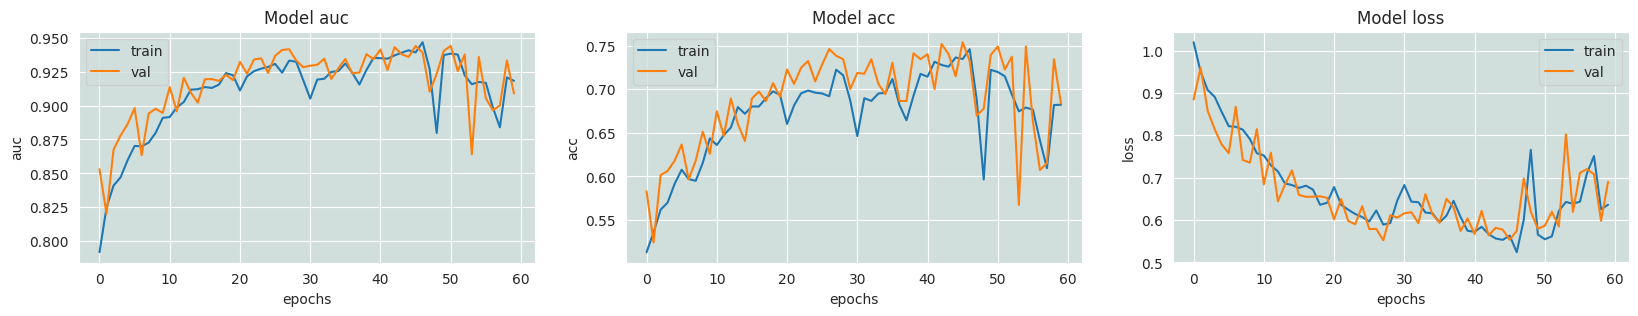

In [ ]:

fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc','acc' , 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

LE FINE-TUNING EN UTILISANT LE MODELE XCEPTION

In [ ]:
Xception_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS)

history2 = Xception_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=60
)

Epoch 1/60
410/410 [==============================] - 39s 60ms/step - loss: 1.1418 - acc: 0.5077 - auc: 0.7932 - tp: 1548.0000 - fp: 1243.0000 - tn: 11048.0000 - fn: 2549.0000 - val_loss: 0.9111 - val_acc: 0.5830 - val_auc: 0.8479 - val_tp: 261.0000 - val_fp: 46.0000 - val_tn: 3026.0000 - val_fn: 763.0000
Epoch 2/60
410/410 [==============================] - 24s 57ms/step - loss: 0.9541 - acc: 0.5279 - auc: 0.8231 - tp: 1374.0000 - fp: 737.0000 - tn: 11554.0000 - fn: 2723.0000 - val_loss: 0.9038 - val_acc: 0.5469 - val_auc: 0.8360 - val_tp: 376.0000 - val_fp: 185.0000 - val_tn: 2887.0000 - val_fn: 648.0000
Epoch 3/60
410/410 [==============================] - 23s 57ms/step - loss: 0.9322 - acc: 0.5438 - auc: 0.8314 - tp: 1408.0000 - fp: 707.0000 - tn: 11584.0000 - fn: 2689.0000 - val_loss: 0.8545 - val_acc: 0.5840 - val_auc: 0.8632 - val_tp: 351.0000 - val_fp: 99.0000 - val_tn: 2973.0000 - val_fn: 673.0000
Epoch 4/60
410/410 [==============================] - 24s 59ms/step - loss: 0.91

GRAPHE XCEPTION

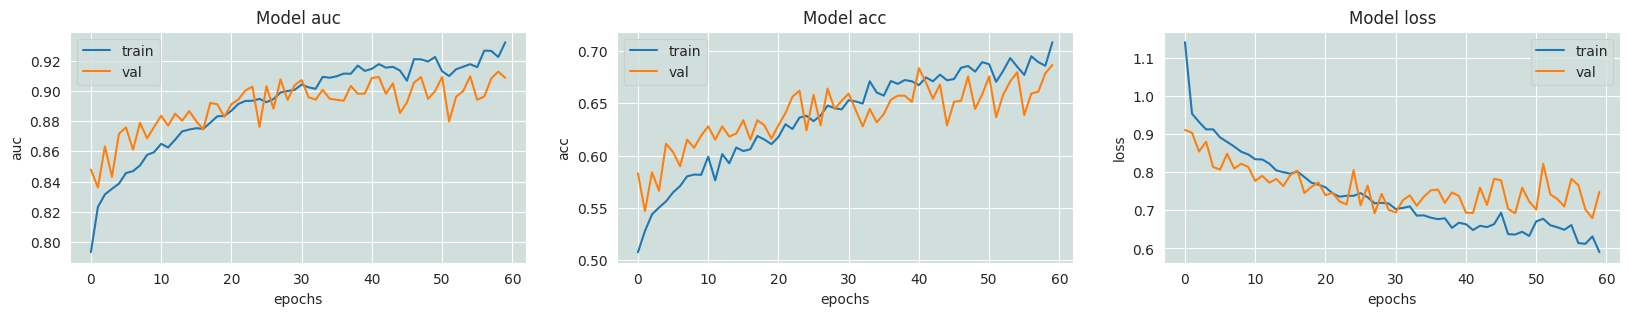

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc','acc', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

LE FINE-TUNING EN UTILISANT LE MODELE VGG16

In [ ]:
VGG_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS)

history3 = VGG_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

410/410 [==============================] - 27s 67ms/step - loss: 0.8884 - acc: 0.5743 - auc: 0.8474 - tp: 1603.0000 - fp: 808.0000 - tn: 11483.0000 - fn: 2494.0000 - val_loss: 0.8863 - val_acc: 0.6006 - val_auc: 0.8552 - val_tp: 310.0000 - val_fp: 62.0000 - val_tn: 3010.0000 - val_fn: 714.0000
Epoch 4/60
410/410 [==============================] - 28s 67ms/step - loss: 0.8551 - acc: 0.5929 - auc: 0.8596 - tp: 1786.0000 - fp: 870.0000 - tn: 11421.0000 - fn: 2311.0000 - val_loss: 1.0386 - val_acc: 0.4814 - val_auc: 0.7895 - val_tp: 345.0000 - val_fp: 277.0000 - val_tn: 2795.0000 - val_fn: 679.0000
Epoch 5/60
410/410 [==============================] - 32s 79ms/step - loss: 0.8364 - acc: 0.6019 - auc: 0.8661 - tp: 1843.0000 - fp: 849.0000 - tn: 11442.0000 - fn: 2254.0000 - val_loss: 0.7978 - val_acc: 0.6211 - val_auc: 0.8840 - val_tp: 440.0000 - val_fp: 112.0000 - val_tn: 2960.0000 - val_fn: 584.0000
Epoch 6/60
410/410 [==============================] - 27s 67ms/step - loss: 0.7989 - acc: 0

GRAPHE VGG16

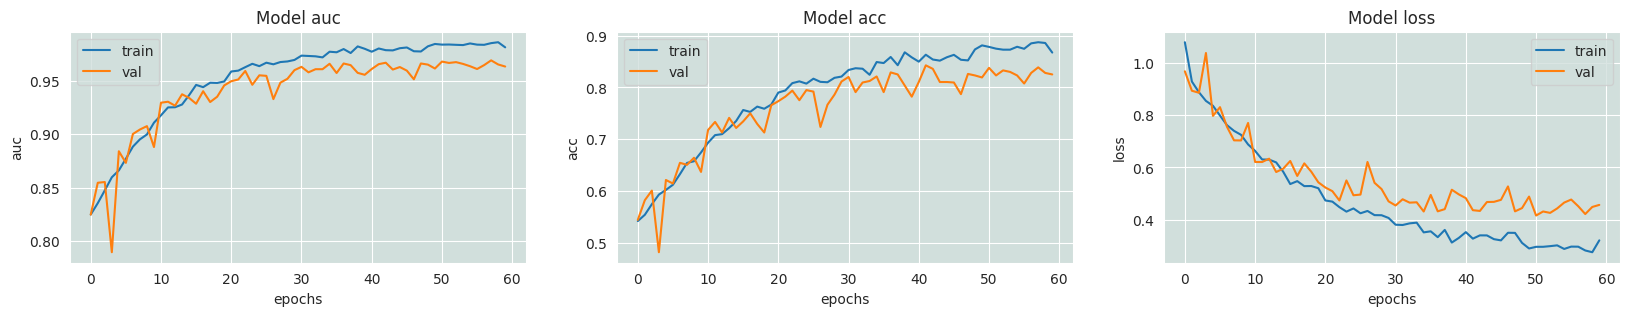

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'acc', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

LEARNING FROM SCRATCH


In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block


In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 208, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 208, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 104, 16)      0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 44, 52, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 22, 26, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 11, 13, 128)       27072     
                                                      

In [ ]:
model = build_model()
model.compile(
        optimizer='Adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS)

history4 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/60
410/410 [==============================] - 35s 38ms/step - loss: 1.4334 - acc: 0.4125 - auc: 0.6810 - tp: 1189.0000 - fp: 1454.0000 - tn: 10837.0000 - fn: 2908.0000 - val_loss: 1.6791 - val_acc: 0.3330 - val_auc: 0.6007 - val_tp: 341.0000 - val_fp: 683.0000 - val_tn: 2389.0000 - val_fn: 683.0000
Epoch 2/60
410/410 [==============================] - 14s 33ms/step - loss: 1.0756 - acc: 0.5140 - auc: 0.7920 - tp: 1537.0000 - fp: 1134.0000 - tn: 11157.0000 - fn: 2560.0000 - val_loss: 1.2444 - val_acc: 0.2246 - val_auc: 0.6224 - val_tp: 76.0000 - val_fp: 186.0000 - val_tn: 2886.0000 - val_fn: 948.0000
Epoch 3/60
410/410 [==============================] - 14s 34ms/step - loss: 1.0167 - acc: 0.5157 - auc: 0.8066 - tp: 1469.0000 - fp: 1033.0000 - tn: 11258.0000 - fn: 2628.0000 - val_loss: 1.9964 - val_acc: 0.3330 - val_auc: 0.7022 - val_tp: 341.0000 - val_fp: 683.0000 - val_tn: 2389.0000 - val_fn: 683.0000
Epoch 4/60
410/410 [==============================] - 14s 33ms/step - loss: 1

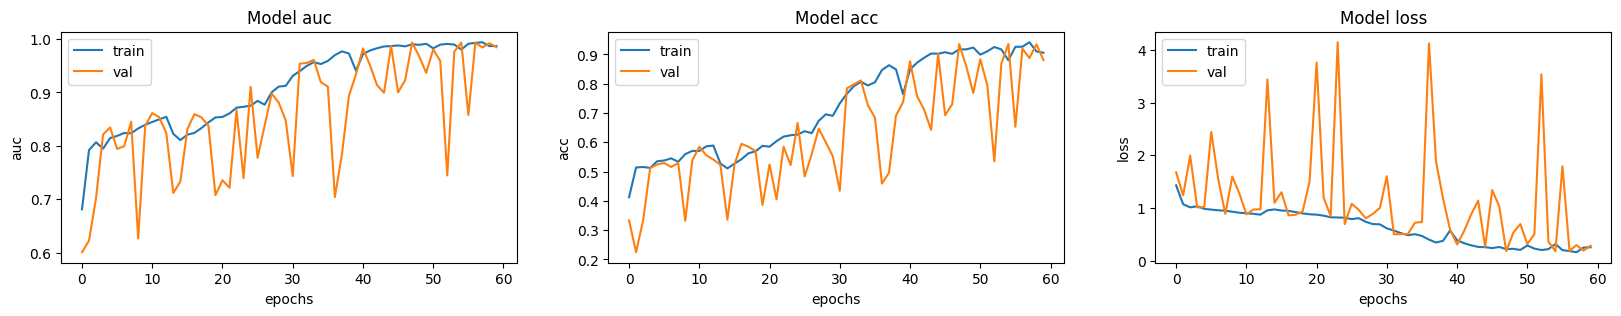

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc','acc', 'loss']):
    ax[i].plot(history4.history[met])
    ax[i].plot(history4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

MODELS EVALUATION

In [ ]:
A = resnet_model.evaluate(train_dataset)
B = Xception_model.evaluate(train_dataset)
C = VGG_model.evaluate(train_dataset)


410/410 [==============================] - 21s 52ms/step - loss: 0.1970 - acc: 0.9304 - auc: 0.9945 - tp: 3769.0000 - fp: 230.0000 - tn: 12061.0000 - fn: 328.0000


In [ ]:
D = model.evaluate(train_dataset)

410/410 [==============================] - 5s 13ms/step - loss: 0.2160 - acc: 0.9456 - auc: 0.9923 - tp: 3850.0000 - fp: 199.0000 - tn: 12092.0000 - fn: 247.0000


In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/test",
    image_size=[224, 224],
    batch_size=BATCH_SIZE,
)
test_dataset = test_dataset.map(one_hot_label, num_parallel_calls=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [ ]:
A = resnet_model.evaluate(test_dataset)
B = Xception_model.evaluate(test_dataset)
C = VGG_model.evaluate(test_dataset)

110/128 [========================>.....] - ETA: 0s - loss: 1.1196 - acc: 0.5491 - auc: 0.8354 - tp: 522.0000 - fp: 376.0000 - tn: 2924.0000 - fn: 578.0000

In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/test",
    image_size=[176, 208],
    batch_size=BATCH_SIZE,
)
test_dataset = test_dataset.map(one_hot_label, num_parallel_calls=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [ ]:
D = model.evaluate(test_dataset)

128/128 [==============================] - 1s 10ms/step - loss: 1.6774 - acc: 0.5528 - auc: 0.8097 - tp: 692.0000 - fp: 544.0000 - tn: 3293.0000 - fn: 587.0000
